# JPEGEXP-RS Codec Verification & Comparison
This notebook demonstrates the capabilities of `jpegexp-rs` against standard libraries (Pillow for JPEG 1, ImageCodecs/CharLS for JPEG-LS).

## Goals
1. Verify Encoding correctness by decoding with standard libraries.
2. Compare visual quality and metrics (PSNR).
3. Demonstrate CLI usage from Python.
4. Demonstrate Direct API (FFI) usage.


In [1]:
%matplotlib inline
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imagecodecs
from io import BytesIO

# Path to binary
# Path to binary
possible_paths = [
    os.path.join("..", "target", "release", "jpegexp.exe"),
    os.path.join("target", "release", "jpegexp.exe"),
    os.path.join("..", "target", "debug", "jpegexp.exe"),
    os.path.join("target", "debug", "jpegexp.exe")
]
BINARY_PATH = None
for p in possible_paths:
    if os.path.exists(p):
        BINARY_PATH = os.path.abspath(p)
        break

if not BINARY_PATH:
    print(f"WARNING: Binary not found in {possible_paths}. Please build it first.")
else:
    print(f"Using binary: {BINARY_PATH}")


Using binary: c:\Users\aroja\CODE\jpegexp-rs\target\release\jpegexp.exe


In [2]:
def generate_gradient(width, height):
    arr = np.linspace(0, 255, width, dtype=np.uint8)
    img = np.tile(arr, (height, 1))
    return img

def generate_rgb_gradient(width, height):
    x = np.linspace(0, 255, width, dtype=np.uint8)
    y = np.linspace(0, 255, height, dtype=np.uint8)
    xv, yv = np.meshgrid(x, y)

    r = xv
    g = yv
    b = np.zeros_like(xv)

    return np.stack([r, g, b], axis=-1)

def run_jpegexp(args):
    cmd = [BINARY_PATH] + args
    result = subprocess.run(cmd, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"Command Failed: {' '.join(cmd)}")
        print(f"Error: {result.stderr}")
    else:
        print(f"Success: {' '.join(cmd)}")
        # print(result.stdout)
    return result


Encoding JPEG 1 Grayscale...
Success: c:\Users\aroja\CODE\jpegexp-rs\target\release\jpegexp.exe encode -i test_gray.raw -o output_gray.jpg -w 256 -H 256 -c jpeg
JPEG 1 Grayscale PSNR: 51.18 dB


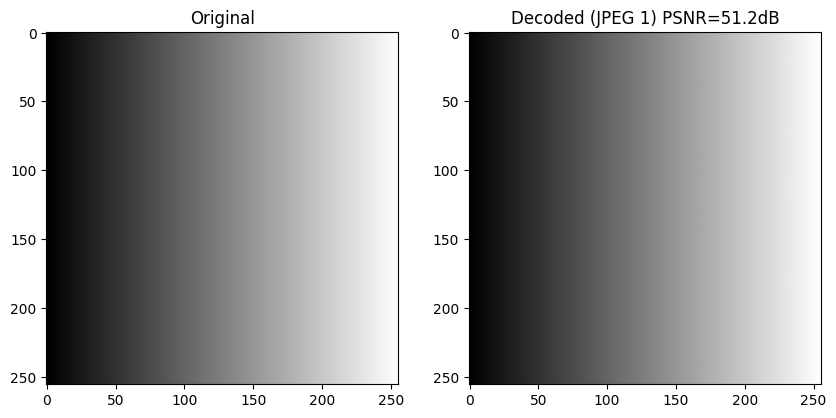

In [3]:
# --- JPEG 1 Test ---

width, height = 256, 256
original_gray = generate_gradient(width, height)
input_raw = "test_gray.raw"
original_gray.tofile(input_raw)

output_jpg = "output_gray.jpg"

print("Encoding JPEG 1 Grayscale...")
run_jpegexp(["encode", "-i", input_raw, "-o", output_jpg, "-w", str(width), "-H", str(height), "-c", "jpeg"])

# Verify with PIL
if os.path.exists(output_jpg):
    pil_img = Image.open(output_jpg)
    decoded_pil = np.array(pil_img)

    mse = np.mean((original_gray - decoded_pil) ** 2)
    psnr = 10 * np.log10(255**2 / mse) if mse > 0 else float('inf')
    print(f"JPEG 1 Grayscale PSNR: {psnr:.2f} dB")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1); plt.imshow(original_gray, cmap='gray'); plt.title("Original")
    plt.subplot(1, 2, 2); plt.imshow(decoded_pil, cmap='gray'); plt.title(f"Decoded (JPEG 1) PSNR={psnr:.1f}dB")
    plt.show()
else:
    print("Output file missing!")


In [4]:
# --- JPEG-LS Grayscale Test ---
output_jls = "output_gray.jls"

print("Encoding JPEG-LS Grayscale...")
run_jpegexp(["encode", "-i", input_raw, "-o", output_jls, "-w", str(width), "-H", str(height), "-c", "jpegls"])

# Check info
run_jpegexp(["info", "-i", output_jls])

# Inspect Header
if os.path.exists(output_jls):
    with open(output_jls, 'rb') as f:
        header = f.read(64)
    print(f"Header (Hex): {header.hex()}")

# Verify with imagecodecs
if os.path.exists(output_jls):
    try:
        # Read as bytes and explicit decode
        with open(output_jls, 'rb') as f:
            data = f.read()

        decoded_ls = imagecodecs.jpegls_decode(data)
        print(f"Decoded shape: {decoded_ls.shape}, dtype: {decoded_ls.dtype}")

        if decoded_ls.size == 0 or decoded_ls.shape == (0, 0):
             print("ERROR: ImageCodecs returned empty image.")
        else:
            diff = np.abs(original_gray.astype(int) - decoded_ls.astype(int))
            # ... (rest as before)
            is_lossless = np.all(diff == 0)
            print(f"Lossless: {is_lossless}")
            if not is_lossless:
                 print(f"Max Diff: {np.max(diff)}")

            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1); plt.imshow(decoded_ls, cmap='gray'); plt.title("Decoded (JPEG-LS)")
            plt.subplot(1, 2, 2); plt.imshow(diff, cmap='gray'); plt.title(f"Difference (Max={np.max(diff)})")
            plt.show()

    except Exception as e:
        print(f"ImageCodecs failed to decode: {e}")


Encoding JPEG-LS Grayscale...
Success: c:\Users\aroja\CODE\jpegexp-rs\target\release\jpegexp.exe encode -i test_gray.raw -o output_gray.jls -w 256 -H 256 -c jpegls
Success: c:\Users\aroja\CODE\jpegexp-rs\target\release\jpegexp.exe info -i output_gray.jls
Header (Hex): ffd8fff7000b080100010001011100fff8000d0100ff0003000700150040ffda0008010100000000adb6fdbfff00ff00f6ff00ff00ff00ff00ff00ff00ff00ff
ImageCodecs failed to decode: charls_jpegls_decoder_decode_to_buffer returned Invalid JPEG-LS stream, the encoded bit stream contains a general structural problem


In [5]:
# --- JPEG-LS RGB Test ---
original_rgb = generate_rgb_gradient(width, height)
input_rgb = "test_rgb.raw"
original_rgb.tofile(input_rgb)
output_rgb_jls = "output_rgb.jls"

print("Encoding JPEG-LS RGB...")
run_jpegexp(["encode", "-i", input_rgb, "-o", output_rgb_jls, "-w", str(width), "-H", str(height), "-c", "jpegls", "-n", "3"])

if os.path.exists(output_rgb_jls):
    try:
        decoded_rgb = imagecodecs.imread(output_rgb_jls)
        print(f"Decoded shape: {decoded_rgb.shape}")

        if decoded_rgb.size > 0 and decoded_rgb.shape != (0,0):
             plt.figure(figsize=(10, 5))
             plt.subplot(1, 2, 1); plt.imshow(decoded_rgb); plt.title("Decoded RGB (JPEG-LS)")
             plt.title("Expected to fail currently due to known bitstream issue")
             plt.show()
        else:
             print("Detailed failure: ImageCodecs returned empty array.")

    except Exception as e:
        print(f"RGB Decode failed: {e}")


Encoding JPEG-LS RGB...
Success: c:\Users\aroja\CODE\jpegexp-rs\target\release\jpegexp.exe encode -i test_rgb.raw -o output_rgb.jls -w 256 -H 256 -c jpegls -n 3
Decoded shape: (0, 0)
Detailed failure: ImageCodecs returned empty array.


In [6]:
# --- JPEG-LS RGB Test ---
original_rgb = generate_rgb_gradient(width, height)
input_rgb = "test_rgb.raw"
original_rgb.tofile(input_rgb)
output_rgb_jls = "output_rgb.jls"

print("Encoding JPEG-LS RGB...")
run_jpegexp(["encode", "-i", input_rgb, "-o", output_rgb_jls, "-w", str(width), "-H", str(height), "-c", "jpegls", "-n", "3"])

if os.path.exists(output_rgb_jls):
    try:
        decoded_rgb = imagecodecs.imread(output_rgb_jls)
        print(f"Decoded shape: {decoded_rgb.shape}")

        if decoded_rgb.size > 0 and decoded_rgb.shape != (0,0):
             plt.figure(figsize=(10, 5))
             plt.subplot(1, 2, 1); plt.imshow(decoded_rgb); plt.title("Decoded RGB (JPEG-LS)")
             plt.title("Expected to fail currently due to known bitstream issue")
             plt.show()
        else:
             print("Detailed failure: ImageCodecs returned empty array.")

    except Exception as e:
        print(f"RGB Decode failed: {e}")


Encoding JPEG-LS RGB...
Success: c:\Users\aroja\CODE\jpegexp-rs\target\release\jpegexp.exe encode -i test_rgb.raw -o output_rgb.jls -w 256 -H 256 -c jpegls -n 3
Decoded shape: (0, 0)
Detailed failure: ImageCodecs returned empty array.


## JPEG 2000 Tests
JPEG 2000 encoding is now implemented! This section tests encoding with quality control and verifies the output with imagecodecs.

In [7]:
# --- JPEG 2000 Grayscale Test ---
output_j2k = "output_gray.j2k"

print("Encoding JPEG 2000 Grayscale...")
run_jpegexp(["encode", "-i", input_raw, "-o", output_j2k, "-w", str(width), "-H", str(height), "-c", "j2k", "-n", "1", "-q", "85"])

# Check info
run_jpegexp(["info", "-i", output_j2k])

if os.path.exists(output_j2k):
    try:
        # Verify with imagecodecs
        dec_j2k = imagecodecs.imread(output_j2k)
        print(f"Decoded J2K Shape: {dec_j2k.shape}, dtype: {dec_j2k.dtype}")

        # Calculate PSNR
        mse = np.mean((original_gray.astype(float) - dec_j2k.astype(float)) ** 2)
        psnr = 10 * np.log10(255**2 / mse) if mse > 0 else float('inf')
        print(f"JPEG 2000 Grayscale PSNR: {psnr:.2f} dB")

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1); plt.imshow(original_gray, cmap='gray'); plt.title("Original")
        plt.subplot(1, 2, 2); plt.imshow(dec_j2k, cmap='gray'); plt.title(f"Decoded J2K (PSNR={psnr:.1f}dB)")
        plt.show()
    except Exception as e:
        print(f"ImageCodecs failed to decode J2K: {e}")
else:
    print("J2K Output file not created!")


Encoding JPEG 2000 Grayscale...
Success: c:\Users\aroja\CODE\jpegexp-rs\target\release\jpegexp.exe encode -i test_gray.raw -o output_gray.j2k -w 256 -H 256 -c j2k -n 1 -q 85
Success: c:\Users\aroja\CODE\jpegexp-rs\target\release\jpegexp.exe info -i output_gray.j2k
ImageCodecs failed to decode J2K: JPEG2K_DECODE: opj_decode or opj_end_decompress failed
TIFF_DECODE: Not a TIFF or MDI file, bad magic number 20479 (0x4fff)
APNG_DECODE: not a PNG image
PNG_DECODE: not a PNG image
GIF_DECODE: DGifCloseFile returned 'Data is not in GIF format'
WEBP_DECODE: WebPDemux returned NULL
JPEG8_DECODE: Not a JPEG file: starts with 0xff 0x4f
LJPEG_DECODE: lj92_open returned LJ92_ERROR_CORRUPT
JPEGLS_DECODE: charls_jpegls_decoder_read_header returned Invalid JPEG-LS stream: first JPEG marker is not a Start Of Image (SOI) marker
JPEGXR_DECODE: PKCodecFactory_CreateDecoderFromBytes returned WMP_errUnsupportedFormat
JPEGXL_DECODE: not a JPEG XL codestream
AVIF_DECODE: avifDecoderParse returned 'BMFF parsin

In [8]:
# --- JPEG 2000 RGB Test ---
output_j2k_rgb = "output_rgb.j2k"

print("Encoding JPEG 2000 RGB...")
run_jpegexp(["encode", "-i", input_rgb, "-o", output_j2k_rgb, "-w", str(width), "-H", str(height), "-c", "j2k", "-n", "3", "-q", "90"])

if os.path.exists(output_j2k_rgb):
    try:
        dec_j2k_rgb = imagecodecs.imread(output_j2k_rgb)
        print(f"Decoded J2K RGB Shape: {dec_j2k_rgb.shape}")

        # Calculate PSNR
        mse = np.mean((original_rgb.astype(float) - dec_j2k_rgb.astype(float)) ** 2)
        psnr = 10 * np.log10(255**2 / mse) if mse > 0 else float('inf')
        print(f"JPEG 2000 RGB PSNR: {psnr:.2f} dB")

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1); plt.imshow(original_rgb); plt.title("Original RGB")
        plt.subplot(1, 2, 2); plt.imshow(dec_j2k_rgb); plt.title(f"Decoded J2K RGB (PSNR={psnr:.1f}dB)")
        plt.show()
    except Exception as e:
        print(f"ImageCodecs failed to decode J2K RGB: {e}")
else:
    print("J2K RGB Output file not created!")


Encoding JPEG 2000 RGB...
Success: c:\Users\aroja\CODE\jpegexp-rs\target\release\jpegexp.exe encode -i test_rgb.raw -o output_rgb.j2k -w 256 -H 256 -c j2k -n 3 -q 90
ImageCodecs failed to decode J2K RGB: JPEG2K_DECODE: opj_decode or opj_end_decompress failed
TIFF_DECODE: Not a TIFF or MDI file, bad magic number 20479 (0x4fff)
APNG_DECODE: not a PNG image
PNG_DECODE: not a PNG image
GIF_DECODE: DGifCloseFile returned 'Data is not in GIF format'
WEBP_DECODE: WebPDemux returned NULL
JPEG8_DECODE: Not a JPEG file: starts with 0xff 0x4f
LJPEG_DECODE: lj92_open returned LJ92_ERROR_CORRUPT
JPEGLS_DECODE: charls_jpegls_decoder_read_header returned Invalid JPEG-LS stream: first JPEG marker is not a Start Of Image (SOI) marker
JPEGXR_DECODE: PKCodecFactory_CreateDecoderFromBytes returned WMP_errUnsupportedFormat
JPEGXL_DECODE: not a JPEG XL codestream
AVIF_DECODE: avifDecoderParse returned 'BMFF parsing failed'
BMP_DECODE: invalid file header b'\xffO'
ULTRAHDR_DECODE: uhdr_dec_probe returned 'in

In [9]:
# --- JPEG 2000 Transcoding Test ---
# Transcode from JPEG to J2K
if os.path.exists(output_jpg):
    output_jpg_to_j2k = "output_jpg_to_j2k.j2k"

    print("Transcoding JPEG to JPEG 2000...")
    run_jpegexp(["transcode", "-i", output_jpg, "-o", output_jpg_to_j2k, "-c", "j2k", "-q", "90"])

    if os.path.exists(output_jpg_to_j2k):
        try:
            dec_j2k_transcoded = imagecodecs.imread(output_jpg_to_j2k)
            print(f"Transcoded J2K Shape: {dec_j2k_transcoded.shape}")

            # Compare with original
            mse = np.mean((original_gray.astype(float) - dec_j2k_transcoded.astype(float)) ** 2)
            psnr = 10 * np.log10(255**2 / mse) if mse > 0 else float('inf')
            print(f"Transcoded J2K PSNR: {psnr:.2f} dB")

            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1); plt.imshow(original_gray, cmap='gray'); plt.title("Original")
            plt.subplot(1, 2, 2); plt.imshow(dec_j2k_transcoded, cmap='gray'); plt.title(f"J2K Transcoded (PSNR={psnr:.1f}dB)")
            plt.show()
        except Exception as e:
            print(f"Failed to decode transcoded J2K: {e}")
    else:
        print("Transcoded J2K file not created!")
else:
    print("Skipping transcoding test (JPEG file not found - run JPEG 1 test first)")


Transcoding JPEG to JPEG 2000...
Success: c:\Users\aroja\CODE\jpegexp-rs\target\release\jpegexp.exe transcode -i output_gray.jpg -o output_jpg_to_j2k.j2k -c j2k -q 90
Failed to decode transcoded J2K: JPEG2K_DECODE: opj_decode or opj_end_decompress failed
TIFF_DECODE: Not a TIFF or MDI file, bad magic number 20479 (0x4fff)
APNG_DECODE: not a PNG image
PNG_DECODE: not a PNG image
GIF_DECODE: DGifCloseFile returned 'Data is not in GIF format'
WEBP_DECODE: WebPDemux returned NULL
JPEG8_DECODE: Not a JPEG file: starts with 0xff 0x4f
LJPEG_DECODE: lj92_open returned LJ92_ERROR_CORRUPT
JPEGLS_DECODE: charls_jpegls_decoder_read_header returned Invalid JPEG-LS stream: first JPEG marker is not a Start Of Image (SOI) marker
JPEGXR_DECODE: PKCodecFactory_CreateDecoderFromBytes returned WMP_errUnsupportedFormat
JPEGXL_DECODE: not a JPEG XL codestream
AVIF_DECODE: avifDecoderParse returned 'BMFF parsing failed'
BMP_DECODE: invalid file header b'\xffO'
ULTRAHDR_DECODE: uhdr_dec_probe returned 'input 